In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import wandb
import tempfile
import os
from models.normalizing_flow import HierarchicalNormalizingFlowSB
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn


In [7]:
from train_flow_sb import unflatten, object_from_config

In [8]:
api = wandb.Api()

In [9]:
run = api.run('druhe/gw-src/16pgb80c')

In [10]:
config = unflatten(run.config)

In [11]:
dataset = object_from_config(config, key='dataset')(**config['dataset'])

In [12]:
sb_weight = config['model']['sb_weight']

In [13]:
flows = object_from_config(config, key='flow')(**config['flow'])

In [14]:
checkpoints = [f for f in run.files() if f.name.endswith('.ckpt')]

In [15]:
tempdir = tempfile.TemporaryDirectory()

In [16]:
ckpt = checkpoints[0]

In [17]:
ckpt_path = ckpt.download(root=tempdir.name, replace=True)

In [18]:
model = HierarchicalNormalizingFlowSB.load_from_checkpoint(ckpt_path.name, dataset=dataset, sb_weight=sb_weight, flows=flows)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmpyjjfl7ap
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmpyjjfl7ap/_remote_module_non_sriptable.py


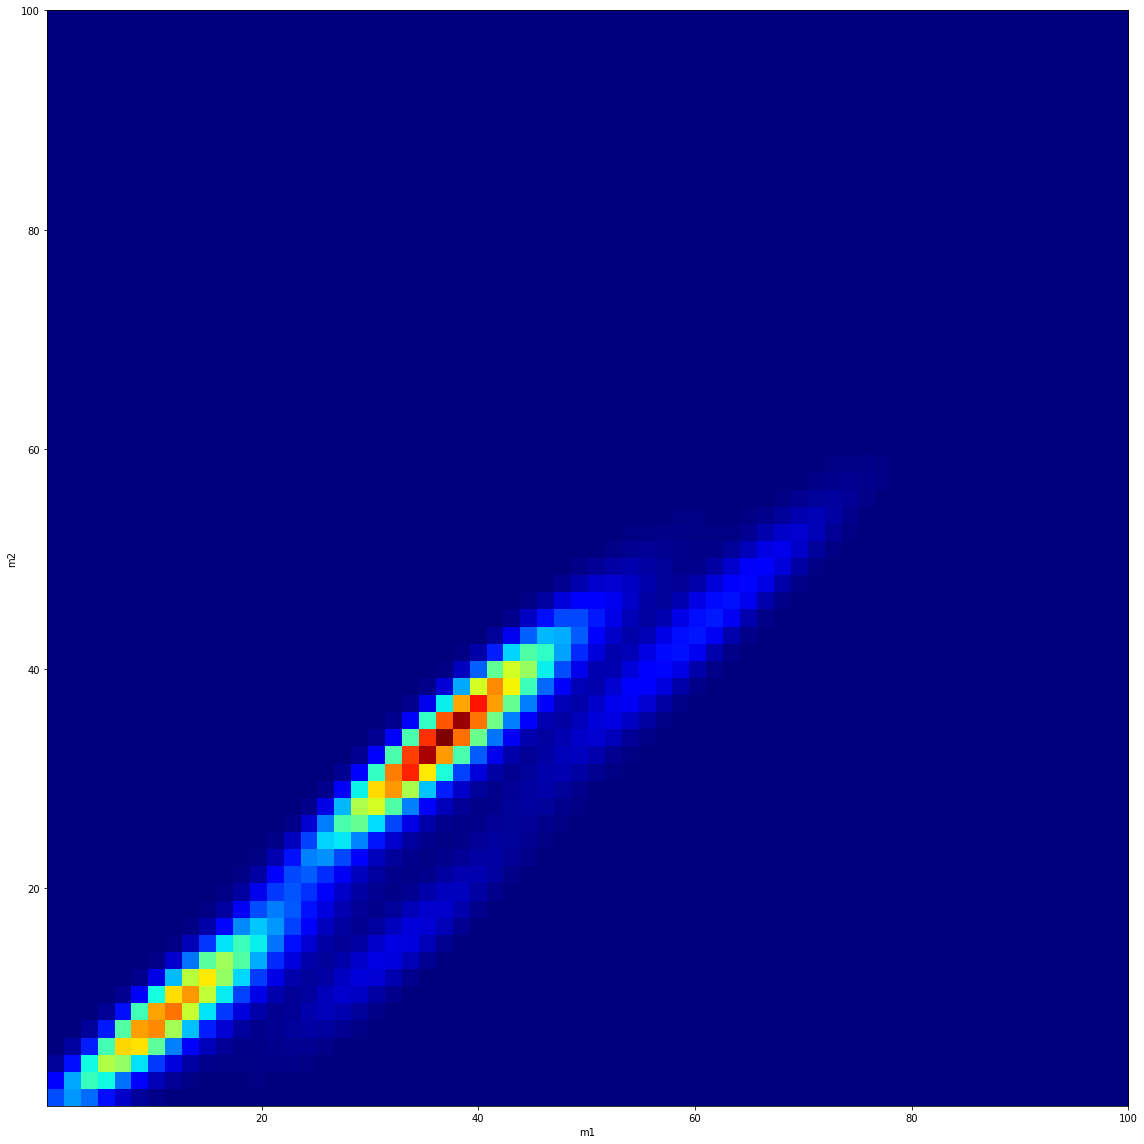

In [21]:
with torch.no_grad():
    axes_names = []
    axes = []

    for n, ax in dataset.grid.items():
        axes_names.append(n)
        axes.append(ax)

    m1, m2, z = np.stack(np.meshgrid(*axes, indexing="xy")).reshape(3, -1)

    if dataset.has_normalization:
        raise NotImplementedError
        x, y = dataset.normalize_forward(x, y)

    resolutions = [len(ax) for ax in axes]

    input = np.stack([m1, m2, z], axis=-1)
    input = torch.from_numpy(input).float()
    prob = model.log_prob(input).exp().view(*resolutions)

    pm1m2 = prob.sum(-1)

    fig = plt.figure(figsize=(16, 16), facecolor="white")
    plt.imshow(
        pm1m2,
        cmap="jet",
        origin="lower",
        extent=(
            axes[0][0],
            axes[0][-1],
            axes[1][0],
            axes[1][-1],
        ),  # origin='lower' changes the order
        aspect="auto",
    )

    plt.xlabel(axes_names[0])  # origin='lower' changes the order
    plt.ylabel(axes_names[1])
    plt.tight_layout()



In [22]:
import hamiltorch
def log_prob(omega):
    mean = torch.tensor([0.,0.,0.])
    stddev = torch.tensor([.5,1.,2.]) 
    return torch.distributions.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()

L = 5
step_size = .3
N = 2048

hamiltorch.set_random_seed(123)
params_init = torch.zeros(3) + 5
burn=500
N_nuts = burn + N
params_hmc_nuts = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_nuts,step_size=step_size,num_steps_per_sample=L,
                                                  sampler=hamiltorch.Sampler.HMC_NUTS, burn=burn,
                                                  desired_accept_rate=0.8)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Final Adapted Step Size:  0.6456695795059204---- |  464/2548 | 184.05       
0d:00:00:14 | 0d:00:00:00 | #################### | 2548/2548 | 180.91       
Acceptance Rate 0.86


In [36]:
def log_prob(x):
    x = x[None]
    return model.log_prob(x).sum()

In [37]:
v, _ = input.median(dim=0)

In [38]:
log_prob(v)

tensor(-12.8418, dtype=torch.float64, grad_fn=<SumBackward0>)

In [39]:
L = 5
step_size = .3
N = 2048

hamiltorch.set_random_seed(123)
params_init = v
burn=500
N_nuts = burn + N
params_hmc_nuts = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_nuts,step_size=step_size,num_steps_per_sample=L,
                                                  sampler=hamiltorch.Sampler.HMC_NUTS, burn=burn,
                                                  desired_accept_rate=0.8)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Invalid log_prob: nan, params: tensor([24.7223, 31.5556, 61.0290], requires_grad=True)
Invalid log_prob: nan, params: tensor([-2.3052e+05,  3.0446e+05,  1.2409e+02], requires_grad=True)
Invalid log_prob: nan, params: tensor([55.0121, 18.4777, 71.2042], requires_grad=True)
Invalid log_prob: nan, params: tensor([40.8461, 38.2147, 48.6447], requires_grad=True)
Invalid log_prob: nan, params: tensor([61.6124, 39.8568,     nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([ 121843.6250, -129401.3047,          nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([59.6905, 46.1356, -0.2148], requires_grad=True)
Invalid log_prob: nan, params: tensor([  32.0512,   25.7173, 1185.4979], requires_grad=True)
Invalid log_prob: nan, params: tensor([ 37.2402,  34.3677, 102.9826], requires_grad=True)
Invalid log_prob: nan, params: tensor([43.4949, 37.1488, 55.08

Invalid log_prob: nan, params: tensor([10.4357, 12.9609, -4.3817], requires_grad=True)
Invalid log_prob: nan, params: tensor([32.4401, 14.5323,     nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([37.5595, 28.7802, 67.1770], requires_grad=True)
Invalid log_prob: nan, params: tensor([34.2641, 32.3486,     nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([15.8850, 10.3021, 29.0323], requires_grad=True)
Invalid log_prob: nan, params: tensor([11.5039, 10.5667, 83.3677], requires_grad=True)
Invalid log_prob: nan, params: tensor([13.7132, 15.7561, -0.2110], requires_grad=True)
Invalid log_prob: nan, params: tensor([ 5.1600,  3.6334, 21.1965], requires_grad=True)
Invalid log_prob: nan, params: tensor([18.8961, 13.4816,     nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([12.5565, 12.2235, 29.6070], requires_grad=True)
Invalid log_prob: nan, params: tensor([5.5440, 0.1395,    nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([10.6995

In [45]:
import seaborn as sns

In [42]:
samples = torch.stack(params_hmc_nuts)